# Extract and convert weird lat-lons

From this conversation >> https://swung.slack.com/archives/C0AG7T5UP/p1593723082091000

You will need [PyProj](https://pypi.org/project/pyproj/):

    python -m pip install pyproj
    
If you want to do the `geopandas` stuff...

    conda install --channel conda-forge geopandas

... and make sure *everything* in your current environment comes from `conda-forge`. Easiest way: set it as your default channel: https://conda-forge.org/docs/user/tipsandtricks.html

## UKA format

This is a 'UKOOA Post plot navigation file'.

Check out the data file:

In [1]:
!head -20 ../data/PON14_BP832D2007.UKA

H0100 Survey Area               83- AND 84- PREFIXES                            
H0103 Source Details            Unknown                                         
H0200 Date of survey            1983                                            
H0202 Tape Version              UKOOA P1/90                                     
H0300 Details of Client         British Petroleum Co                            
H0400 Geophysical Contractor    HORIZON                                         
H1400 Coordinate location       Unknown                                         
H1500 Geodetic datum as plotted ED50       INTERNAT1924                         
H2600 Exported from DTI 2D database and loaded to CDA database in 2000.       
Z83-602               101601958.10N  43410.10W                                  
Z83-602               110601953.80N  43421.90W                                  
Z83-602               120601948.70N  43434.50W                                  
Z83-602               13060194

In [4]:
int('  45')

45

In [10]:
from collections import defaultdict

with open("../data/PON14_BP832D2007.UKA") as f:
    data = f.readlines()

lines = defaultdict(lambda: defaultdict(list))
for s in data:
    if s[0] == 'H':
        continue
    
    name = s[:20].strip()
    lines[name]['cdps'].append(int(s[20:25]))
    lines[name]['lats'].append((s[25:27], s[27:29], s[29:34], s[34:35]))
    lines[name]['lons'].append((s[35:38], s[38:40], s[40:45], s[45:46]))

Convert to decimal degrees:

In [12]:
def dms_to_dd(dmsa):
    d, m, s, a = dmsa
    return (float(d) + float(m)/60 + float(s)/(60*60)) * (-1 if a.upper() in ['W', 'S'] else 1)

for line, data in lines.items():
    lines[line]['lats'] = [dms_to_dd(dms) for dms in data['lats']]
    lines[line]['lons'] = [dms_to_dd(dms) for dms in data['lons']]

I think this is the source CRS: https://epsg.io/4230-8046

In [17]:
from pyproj import Transformer
import numpy as np
from shapely.geometry import LineString

t = Transformer.from_crs('epsg:4230', 'epsg:32631')

for line, data in lines.items():
    coords = zip(data['lats'], data['lons'])
    xys = np.array([t.transform(lon, lat) for lat, lon in coords])
    lines[line]['linestring'] = LineString(xys)

In [23]:
import geopandas as gpd

gdf = gpd.GeoDataFrame([(k, v['linestring']) for k, v in lines.items()],
                       columns=['name', 'geometry'])

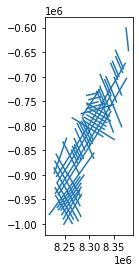

In [24]:
gdf.plot()